# Tutorial4: Convolutional Layers - Spectral methods

## Outline

- Why convolution in ML
- Some theory on convolution
- Convolution on graphs
- Spectral-convolutional layers in PyTorch Geometric

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.5.1


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

## Why convolution in ML

- Weight sharing
- Detection of translational invariant and local features

![](fig/fully_connected.png)
[Source](https://missinglink.ai/guides/convolutional-neural-networks/fully-connected-layers-convolutional-neural-networks-complete-guide/)

![](fig/cnn.gif)
[Source](https://commons.wikimedia.org/wiki/File:Convolutional_Neural_Network.gif)

![](fig/Convolution.png)
[Source](https://commons.wikimedia.org/wiki/File:Convolution.PNG)

## Some theory on convolution

![](fig/Convolution_of_box_signal_with_itself2.gif)
[Source](https://en.wikipedia.org/wiki/File:Convolution_of_box_signal_with_itself2.gif)

### Definition

\begin{align*}
c[n] = (v * w)[n] = \sum_{m=0}^{N-1} v[m] \cdot w[n-m]
\end{align*}

In [3]:
def conv(v, w):
    c = np.zeros(v.shape)
    for n in range(len(v)):
        c[n] = 0
        for m in range(len(v)):
            c[n] += v[m] * w[n - m]  
    return c

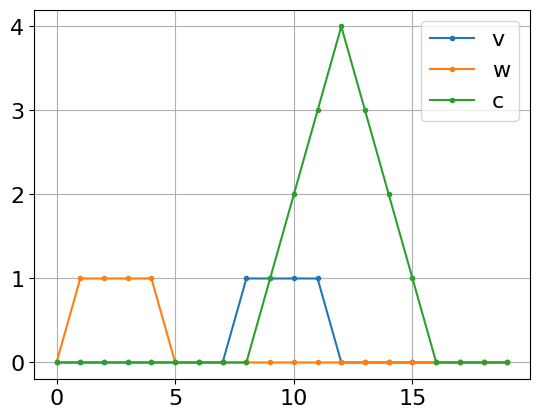

In [4]:
N = 20
v = np.zeros(N)
v[8:12] = 1
w = np.zeros(N)
w[1:5] = 1
c = conv(v, w)

fig = plt.figure()
ax = fig.gca()
ax.plot(v, '.-')
ax.plot(w, '.-')
ax.plot(c, '.-')
ax.legend(['v', 'w', 'c'])
ax.grid(True)

### Fourier transform

Transformation $\mathcal F: \mathbb{R}^N \to \mathbb{R}^N$ with

\begin{align*}
\mathcal F^{-1}(\mathcal F (v)) &= v\\
\mathcal F(v * w) &= \mathcal F(v) \cdot \mathcal F(w).
\end{align*}

This implies
\begin{align*}
v * w &= \mathcal F^{-1}(\mathcal F (v * w))\\
&= \mathcal F^{-1}(\mathcal F(v) \cdot \mathcal F(w))
\end{align*}


### Convolution Theorem Explanation (PyTorch Example)

The formula **F(v \* w) = F(v) \* F(w)** represents the **Convolution Theorem**.

It states that the Fourier Transform of the convolution of two signals is equal to the pointwise product of their individual Fourier Transforms.

This Python code demonstrates the theorem using PyTorch for **linear convolution**:

1.  **Signal Creation**: Two complex 1D signals, `v` and `w`, are created using `torch.randn`. Complex numbers are used as FFT naturally produces complex results.
2.  **Padding for Linear Convolution**: To compute linear convolution using FFT, the signals must be zero-padded. The required length is `n_fft = len(v) + len(w) - 1`. The signals `v` and `w` are padded to this length using `torch.nn.functional.pad` (or `F.pad`).
3.  **Convolution via FFT**: The convolution `conv_result` is calculated efficiently using the standard FFT approach:
    *   Compute the Fast Fourier Transforms (FFTs) of the padded signals: `F_v_padded = torch.fft.fft(v_padded)` and `F_w_padded = torch.fft.fft(w_padded)`.
    *   Multiply these FFTs pointwise in the frequency domain: `F_conv = F_v_padded * F_w_padded`.
    *   Compute the inverse FFT of the product to get the convolution result back in the time domain: `conv_result = torch.fft.ifft(F_conv)`.
4.  **Calculate LHS**: The Left-Hand Side of the theorem, `F(v * w)`, is calculated by taking the FFT of the time-domain convolution result obtained in the previous step: `lhs = torch.fft.fft(conv_result)`.
5.  **Calculate RHS**: The Right-Hand Side of the theorem, `F(v) * F(w)`, is simply the pointwise product of the individual FFTs of the padded signals, which was already calculated as `F_conv`: `rhs = F_v_padded * F_w_padded`.
6.  **Verification**: The code verifies that the calculated LHS and RHS are numerically very close using `torch.allclose()`. This confirms the Convolution Theorem holds (within the limits of floating-point precision).

In summary, the theorem allows replacing a potentially complex convolution operation in the time/spatial domain with a simpler pointwise multiplication in the frequency domain, which is often computationally advantageous.

In [4]:
import torch
import torch.fft
import torch.nn.functional as F

# --- Settings ---
L = 10 # Length of signals
USE_COMPLEX = False # Set to True to use complex, False for real (easier conv1d demo)
DTYPE = torch.complex64 if USE_COMPLEX else torch.float32

# --- 1. Create Signals ---
v = torch.randn(L, dtype=DTYPE)
w = torch.randn(L, dtype=DTYPE)
# Reverse w for conv1d, as it performs cross-correlation by default
w_rev = torch.flip(w, dims=[0])

print(f"Signal v (length {L}):\n{v}")
print(f"\nSignal w (length {L}):\n{w}")
if not USE_COMPLEX:
    print(f"\nReversed w (for conv1d): \n{w_rev}")


# --- 2. Direct Convolution Calculation (using conv1d for real signals) ---
conv_direct = None
if not USE_COMPLEX:
    # conv1d expects input (N, C_in, L_in) and weight (C_out, C_in, L_kernel)
    # N=1 (batch size), C_in=1 (channels), C_out=1
    v_reshaped = v.view(1, 1, L)
    w_rev_reshaped = w_rev.view(1, 1, L)

    # Use padding='valid' for linear convolution result of length L+L-1
    # Need to pad the *input* signal v appropriately first
    padding_size = L - 1
    v_padded_for_conv1d = F.pad(v_reshaped, (padding_size, padding_size)) # Pad both sides for 'valid' conv

    # Perform convolution
    conv_direct_torch = F.conv1d(v_padded_for_conv1d, w_rev_reshaped, padding='valid')
    conv_direct = conv_direct_torch.squeeze() # Remove batch/channel dims
    print(f"\nDirect Convolution (conv1d, length {len(conv_direct)}):\n{conv_direct}")
else:
    print("\nDirect convolution with conv1d not shown for complex signals.")
    # For complex, direct calculation would need manual implementation or numpy


# --- 3. Convolution Calculation via FFT Method ---
n_fft = L + L - 1 # Padded length for linear convolution
v_padded_fft = F.pad(v, (0, n_fft - L))
w_padded_fft = F.pad(w, (0, n_fft - L))

F_v_padded = torch.fft.fft(v_padded_fft)
F_w_padded = torch.fft.fft(w_padded_fft)
F_conv = F_v_padded * F_w_padded
conv_fft_method = torch.fft.ifft(F_conv)

# For real inputs, the result of ifft should be real (imaginary part is near zero)
if not USE_COMPLEX:
    conv_fft_method = conv_fft_method.real

print(f"\nConvolution via FFT (length {len(conv_fft_method)}):\n{conv_fft_method}")

# --- 4. Compare Direct vs FFT Convolution Results ---
if conv_direct is not None:
    are_conv_methods_close = torch.allclose(conv_direct, conv_fft_method, atol=1e-5)
    print(f"\nAre Direct Conv (conv1d) and FFT Conv results close? {are_conv_methods_close}")
    if not are_conv_methods_close:
        max_diff_conv = torch.max(torch.abs(conv_direct - conv_fft_method))
        print(f"Max absolute difference between conv methods: {max_diff_conv}")

# --- 5. Verify Convolution Theorem using one of the results ---
# Let's use the FFT method result (conv_fft_method) as the reference convolution `v * w`
# We need its FFT for the LHS.
# Important: Use the complex result *before* taking .real if input was real
lhs_fft = torch.fft.fft(torch.fft.ifft(F_conv)) # FFT(v*w) = FFT(ifft(F(v)*F(w))) = F(v)*F(w)

# RHS is the product of the individual FFTs
rhs_fft = F_v_padded * F_w_padded # F(v) * F(w)

print(f"\n--- Verifying Theorem: F(v*w) = F(v)*F(w) ---")
print(f"LHS = FFT(Convolution Result) [length {len(lhs_fft)}]:\n{lhs_fft}")
print(f"\nRHS = FFT(v_padded) * FFT(w_padded) [length {len(rhs_fft)}]:\n{rhs_fft}")

are_theorem_sides_close = torch.allclose(lhs_fft, rhs_fft, atol=1e-6)
print(f"\nAre LHS and RHS of the theorem approximately equal? {are_theorem_sides_close}")
if not are_theorem_sides_close:
    max_diff_theorem = torch.max(torch.abs(lhs_fft - rhs_fft))
    print(f"Max absolute difference between theorem sides: {max_diff_theorem}")

Signal v (length 10):
tensor([-0.1561,  0.7400, -0.6978, -1.5155,  0.5595,  0.0286,  0.5866, -0.6230,
         0.6650,  1.7772])

Signal w (length 10):
tensor([-0.2394,  0.8225, -0.4167,  0.0106,  1.2446,  0.5362,  1.0994,  0.4334,
         0.4368,  1.4826])

Reversed w (for conv1d): 
tensor([ 1.4826,  0.4368,  0.4334,  1.0994,  0.5362,  1.2446,  0.0106, -0.4167,
         0.8225, -0.2394])

Direct Convolution (conv1d, length 19):
tensor([ 0.0374, -0.3055,  0.8407, -0.5212, -1.2761,  1.9148, -1.0095, -0.8888,
        -1.5466, -1.1538,  2.6741, -2.6170, -0.8326,  2.9798,  1.7126,  2.8395,
         0.1371,  1.7622,  2.6348])

Convolution via FFT (length 19):
tensor([ 0.0374, -0.3055,  0.8407, -0.5212, -1.2761,  1.9148, -1.0095, -0.8888,
        -1.5466, -1.1538,  2.6741, -2.6170, -0.8326,  2.9798,  1.7126,  2.8395,
         0.1371,  1.7622,  2.6348])

Are Direct Conv (conv1d) and FFT Conv results close? True

--- Verifying Theorem: F(v*w) = F(v)*F(w) ---
LHS = FFT(Convolution Result) [len

### The Graph Laplacian Matrix

The **Laplacian matrix** is a fundamental matrix representation of a graph, widely used in spectral graph theory, machine learning (e.g., spectral clustering, dimensionality reduction), network analysis, and physics (e.g., modeling diffusion). It captures information about the connectivity and structure of the graph.

#### Preliminaries: Graph Definitions

Let $G = (V, E)$ be a graph, where:
*   $V = \{v_1, v_2, ..., v_n\}$ is the set of $n$ vertices (or nodes).
*   $E$ is the set of edges connecting pairs of vertices. We'll primarily consider an **undirected, unweighted** graph first.

#### Key Matrices

1.  **Adjacency Matrix ($A$)**:
    *   An $n \times n$ matrix where $A_{ij} = 1$ if there is an edge between vertex $v_i$ and vertex $v_j$, and $A_{ij} = 0$ otherwise.
    *   For an undirected graph, $A$ is symmetric ($A_{ij} = A_{ji}$).
    *   $A_{ii}$ is typically 0 (no self-loops).

    $A_{ij} = \begin{cases} 1 & \text{if } (v_i, v_j) \in E \\ 0 & \text{otherwise} \end{cases}$

2.  **Degree Matrix ($D$)**:
    *   An $n \times n$ diagonal matrix where the diagonal entry $D_{ii}$ is the **degree** of vertex $v_i$, denoted as $\text{deg}(v_i)$. The degree is the number of edges connected to that vertex.
    *   All off-diagonal entries are 0.

    $D_{ii} = \text{deg}(v_i) = \sum_{j=1}^{n} A_{ij}$
    $D_{ij} = 0 \quad \text{if } i \neq j$

#### Definition of the Laplacian Matrix ($L$)

The (combinatorial) Laplacian matrix $L$ of the graph $G$ is defined as the difference between the Degree Matrix $D$ and the Adjacency Matrix $A$:

$$ L = D - A $$

#### Element-wise Definition

The elements $L_{ij}$ of the Laplacian matrix can be defined explicitly as:

$$
L_{ij} = \begin{cases}
\text{deg}(v_i) & \text{if } i = j \\
-1 & \text{if } i \neq j \text{ and } (v_i, v_j) \in E \\
0 & \text{if } i \neq j \text{ and } (v_i, v_j) \notin E
\end{cases}
$$

#### Example

Consider a simple graph with 3 nodes:
*   Edges: (1, 2), (2, 3)

1.  **Adjacency Matrix ($A$)**:
    $$ A = \begin{pmatrix} 0 & 1 & 0 \\ 1 & 0 & 1 \\ 0 & 1 & 0 \end{pmatrix} $$
2.  **Degrees**: $\text{deg}(v_1)=1$, $\text{deg}(v_2)=2$, $\text{deg}(v_3)=1$
3.  **Degree Matrix ($D$)**:
    $$ D = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 2 & 0 \\ 0 & 0 & 1 \end{pmatrix} $$
4.  **Laplacian Matrix ($L = D - A$)**:
    $$ L = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 2 & 0 \\ 0 & 0 & 1 \end{pmatrix} - \begin{pmatrix} 0 & 1 & 0 \\ 1 & 0 & 1 \\ 0 & 1 & 0 \end{pmatrix} = \begin{pmatrix} 1 & -1 & 0 \\ -1 & 2 & -1 \\ 0 & -1 & 1 \end{pmatrix} $$

#### Properties and Significance

*   **Symmetric**: For undirected graphs, $L$ is always symmetric ($L = L^T$).
*   **Positive Semi-definite**: All eigenvalues of $L$ are non-negative ($\lambda_i \ge 0$).
*   **Row Sums**: The sum of each row (and column, due to symmetry) is zero: $\sum_{j=1}^{n} L_{ij} = 0$ for all $i$.
*   **Smallest Eigenvalue**: The smallest eigenvalue is always 0 ($\lambda_1 = 0$), and its corresponding eigenvector is the vector of all ones, $\mathbf{1} = (1, 1, ..., 1)^T$.
*   **Number of Connected Components**: The *multiplicity* of the eigenvalue 0 is equal to the number of connected components in the graph. For a connected graph, $\lambda_2 > 0$.
*   **Fiedler Value**: The second smallest eigenvalue ($\lambda_2$) is called the Fiedler value or algebraic connectivity. It provides information about how well-connected the graph is. A larger $\lambda_2$ indicates better connectivity.
*   **Applications**: Used in spectral clustering, graph partitioning, random walks, network analysis, image processing, and solving differential equations on graphs (like the heat equation or wave equation).

#### Variants (Normalized Laplacians)

There are also normalized versions of the Laplacian, which are often preferred in machine learning applications:

1.  **Symmetric Normalized Laplacian ($\mathcal{L}_{\text{sym}}$)**:
    $$ \mathcal{L}_{\text{sym}} = D^{-1/2} L D^{-1/2} = I - D^{-1/2} A D^{-1/2} $$
    (Requires $D_{ii} > 0$ for all $i$). Its eigenvalues are between 0 and 2.

2.  **Random Walk Normalized Laplacian ($\mathcal{L}_{\text{rw}}$)**:
    $$ \mathcal{L}_{\text{rw}} = D^{-1} L = I - D^{-1} A $$
    (Requires $D_{ii} > 0$ for all $i$). Related to random walks on the graph. Its eigenvalues are between 0 and 2.

These normalized forms often handle variations in node degrees more effectively than the combinatorial Laplacian.

### The Laplace Operator (Vector Calculus)

When "Laplacian" is mentioned outside the specific context of graph theory, it usually refers to the **Laplace operator**, denoted by $\Delta$ or $\nabla^2$ (read as "del squared"). This is a fundamental differential operator in vector calculus and physics. It operates on scalar fields (functions of multiple variables) or vector fields.

#### Definition in Continuous Space

For a scalar function $f$ of $N$ variables $(x_1, x_2, ..., x_N)$, the Laplacian is defined as the **divergence of the gradient**:

$$ \Delta f = \nabla^2 f = \nabla \cdot (\nabla f) = \sum_{i=1}^{N} \frac{\partial^2 f}{\partial x_i^2} $$

In simpler terms, it's the sum of all the *unmixed* second partial derivatives of the function.

*   **In 2D Cartesian Coordinates $(x, y)$**:
    For a function $f(x, y)$,
    $$ \Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} $$

*   **In 3D Cartesian Coordinates $(x, y, z)$**:
    For a function $f(x, y, z)$,
    $$ \Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} + \frac{\partial^2 f}{\partial z^2} $$

#### Interpretation

The Laplacian measures the "curvature" or "roughness" of a function at a point.
*   If $\Delta f > 0$ at a point, the value of $f$ at that point is lower than its average value in the immediate neighborhood (like a local minimum or valley).
*   If $\Delta f < 0$ at a point, the value of $f$ at that point is higher than its average value in the immediate neighborhood (like a local maximum or peak).
*   If $\Delta f = 0$, the function is "smooth" in the sense that its value at the point is equal to the average of its neighbors (satisfies the mean value property). Functions satisfying $\Delta f = 0$ are called **harmonic functions**. Laplace's equation, $\Delta f = 0$, is crucial in physics (electromagnetism, fluid dynamics, heat conduction).

#### Discretization and Matrix Representation (Finite Differences)

While the Laplace operator is defined continuously, it's often approximated numerically on discrete grids (like pixels in an image or points in a simulation). This is commonly done using **finite differences**.

Consider a 1D function $f(x)$ sampled at discrete points $..., f_{i-1}, f_i, f_{i+1}, ...$ with spacing $h$. The second derivative can be approximated as:

$$ \frac{d^2 f}{dx^2} \bigg|_i \approx \frac{f_{i+1} - 2f_i + f_{i-1}}{h^2} $$

Consider a 2D function $f(x, y)$ sampled on a grid $f_{i,j}$ with spacing $h$ in both directions. The Laplacian is approximated as:

$$ \Delta f \bigg|_{i,j} \approx \frac{f_{i+1, j} + f_{i-1, j} + f_{i, j+1} + f_{i, j-1} - 4f_{i, j}}{h^2} $$

This approximation can be represented by applying a **convolution kernel (or stencil)** to the grid:

$$ \frac{1}{h^2} \begin{pmatrix} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{pmatrix} * f $$
(Ignoring the $1/h^2$ scaling for simplicity, the kernel is often shown as just the matrix part).

When you apply this operation across the entire grid (handling boundary conditions appropriately), it can be formulated as a large **matrix multiplication**. If you arrange the grid points $f_{i,j}$ into a single long vector $\mathbf{f}$, the discrete Laplacian operation becomes:

$$ \Delta \mathbf{f} \approx M \mathbf{f} $$

Where $M$ is a large, sparse matrix. The structure of this matrix $M$ is closely related to the **Graph Laplacian** matrix of the underlying grid graph (where each grid point is a node connected to its immediate neighbors). This is why the term "Laplacian matrix" is used in both contexts. The matrix $M$ derived from the finite difference approximation of the $\nabla^2$ operator will have:
*   Diagonal entries corresponding to the center of the stencil (e.g., -4 in the 2D case).
*   Off-diagonal entries corresponding to the neighbors in the stencil (e.g., 1 for the 4 neighbors in the 2D case).
*   Zeros elsewhere.

This structure ($M \approx -L_{\text{grid graph}}$, up to scaling and sign conventions) connects the continuous Laplace operator to the discrete Graph Laplacian.

### Connecting the Laplacians: Differential Operator, Graph Matrix, and Fourier Transform

Yes, there are deep and important connections between these three concepts, although the "Laplacian for Fourier transform" isn't a separate entity but rather describes *how the Laplace operator behaves under the Fourier transform*. Let's break down the connections:

1.  **Laplace Operator ($\Delta$)**:
    *   **Definition**: A differential operator measuring the divergence of the gradient. In Cartesian coordinates: $\Delta f = \sum_{i} \frac{\partial^2 f}{\partial x_i^2}$.
    *   **Domain**: Continuous functions (scalar or vector fields) defined on Euclidean space (like $\mathbb{R}^2$, $\mathbb{R}^3$).
    *   **Interpretation**: Measures local curvature or the difference between a point's value and the average value of its infinitesimal neighbors.

2.  **Graph Laplacian ($L$)**:
    *   **Definition**: A matrix derived from a graph's structure, typically $L = D - A$ (Degree matrix minus Adjacency matrix).
    *   **Domain**: Functions defined on the vertices of a graph (assigning a value to each node).
    *   **Interpretation**: Measures the difference between a node's value and the *sum* (or average, for normalized versions) of its neighbors' values. For a function $f$ defined on vertices: $(Lf)_i = \sum_{j \sim i} (f_i - f_j)$, where $j \sim i$ means $j$ is a neighbor of $i$. This clearly shows it measures local differences.

3.  **Laplacian and the Fourier Transform**:
    *   **Concept**: This describes a fundamental property relating the Laplace operator ($\Delta$) and the continuous Fourier Transform ($\mathcal{F}$).
    *   **Property**: The Fourier Transform converts differentiation into multiplication by frequency variables (up to constants like $i$ and $2\pi$). Specifically, for the second derivative:
        $$ \mathcal{F}\left( \frac{\partial^2 f}{\partial x_i^2} \right)(\mathbf{k}) = (-i k_i)^2 \mathcal{F}(f)(\mathbf{k}) = -k_i^2 \hat{f}(\mathbf{k}) $$
        (Here, $\hat{f}(\mathbf{k}) = \mathcal{F}(f)(\mathbf{k})$ is the Fourier transform of $f$, and $\mathbf{k} = (k_1, ..., k_N)$ is the frequency vector).
    *   **Laplacian Property**: Applying this to the sum of second derivatives, the Fourier Transform turns the Laplace operator into multiplication by the negative squared magnitude of the frequency vector:
        $$ \mathcal{F}(\Delta f)(\mathbf{k}) = \sum_{i=1}^{N} \mathcal{F}\left( \frac{\partial^2 f}{\partial x_i^2} \right)(\mathbf{k}) = \sum_{i=1}^{N} (-k_i^2) \hat{f}(\mathbf{k}) = - \left(\sum_{i=1}^{N} k_i^2\right) \hat{f}(\mathbf{k}) = - ||\mathbf{k}||^2 \hat{f}(\mathbf{k}) $$
    *   **Significance**: Applying the Laplacian in the spatial domain corresponds to a simple *multiplication* by $-||\mathbf{k}||^2$ in the frequency domain. This simplifies solving differential equations involving the Laplacian (like the heat or wave equation).

#### The Connections:

1.  **Continuous $\Delta$ $\longleftrightarrow$ Discrete $L$ (Discretization)**:
    *   The **Graph Laplacian ($L$) is the natural discrete analogue of the continuous Laplace operator ($\Delta$)**.
    *   If you consider a regular grid (like pixels in an image) as a graph where each node is connected to its neighbors, and you approximate the second partial derivatives using finite differences (as shown previously), the resulting matrix operation that approximates $\Delta$ is precisely the Graph Laplacian matrix (up to scaling and sign conventions) of that grid graph.
    *   The formula $(Lf)_i = \sum_{j \sim i} (f_i - f_j)$ directly mirrors the idea of comparing a point's value to its neighbors, just like $\Delta$.

2.  **Continuous $\Delta$ & Fourier Transform $\longleftrightarrow$ Graph $L$ & Graph Fourier Transform**:
    *   Just as the continuous Fourier Transform simplifies the action of $\Delta$ into multiplication by $-||\mathbf{k}||^2$, there's an analogous concept for graphs called the **Graph Fourier Transform (GFT)**.
    *   The GFT uses the **eigenvectors** of the Graph Laplacian ($L$) as its basis functions (analogous to the complex exponentials $e^{i\mathbf{k}\cdot\mathbf{x}}$ in the continuous FT).
    *   The **eigenvalues** ($\lambda_i$) of the Graph Laplacian $L$ play the role analogous to the squared frequencies $||\mathbf{k}||^2$. They represent notions of "frequency" or "variation" over the graph structure.
    *   **Property**: Applying the Graph Laplacian $L$ to a function $f$ on the graph corresponds to *multiplication by the eigenvalues* in the Graph Fourier (spectral) domain. If $f = \sum_i c_i \mathbf{u}_i$ (where $\mathbf{u}_i$ are eigenvectors of $L$ with eigenvalues $\lambda_i$, and $c_i$ are GFT coefficients), then $Lf = \sum_i c_i (L\mathbf{u}_i) = \sum_i c_i (\lambda_i \mathbf{u}_i)$. In the GFT domain, this is simply multiplying the coefficients $c_i$ by $\lambda_i$.

#### Summary Table:

| Feature             | Continuous Laplace ($\Delta$)                     | Graph Laplacian ($L$)                                  |
| :------------------ | :------------------------------------------------ | :----------------------------------------------------- |
| **Domain**          | Continuous functions on $\mathbb{R}^N$            | Discrete functions on graph vertices                   |
| **Nature**          | Differential Operator                             | Matrix Operator                                        |
| **Interpretation**  | Local curvature / Avg. difference w/ neighbors    | Sum of differences w/ neighbors                        |
| **Connection**      | $\Delta$ is approximated by $L$ on grid graphs    | $L$ is a discretization of $\Delta$                    |
| **"Fourier" Domain**| Continuous Fourier Transform                      | Graph Fourier Transform (Eigenvectors of $L$)          |
| **Action in Fourier**| Multiplication by $-||\mathbf{k}||^2$             | Multiplication by Eigenvalues $\lambda_i$              |

In essence, the Graph Laplacian generalizes the concept of the Laplace operator from continuous Euclidean spaces to the discrete structure of graphs. Both operators measure local variation, and both have the crucial property that their action becomes simple multiplication in their respective frequency/spectral domains defined by appropriate Fourier transforms.

In [33]:
x=torch.arange(10).float()
y=torch.sin(x)

print(F.conv1d(x.reshape((1,1,10)),y.reshape((1,1,10))))
torch.fft.ifft(torch.fft.fft(x).abs()*torch.fft.fft(y).abs()).abs().mean()

tensor([[[9.8079]]])


tensor(8.7984)

In [34]:
a=torch.arange(4).reshape((2,2))
b=torch.tensor([0,2])
a@b

tensor([2, 6])

In [35]:
v, w = np.random.rand(N), np.random.rand(N)
conv(v, w)

NameError: name 'np' is not defined

In [ ]:
a=np.arange(9)
b=np.arange(9)+6
fft(a)*fft(b)

array([3240.          -0.j        , -132.60980145-111.27283549j,
         -8.51060167 -48.2660205j ,   13.5        -23.3826859j ,
         19.62040312  -7.14124272j,   19.62040312  +7.14124272j,
         13.5        +23.3826859j ,   -8.51060167 +48.2660205j ,
       -132.60980145+111.27283549j])

In [ ]:
from scipy.fft import fft, ifft # Fast Fourier Transform / Inverse FFT
np.abs(ifft(fft(v) * fft(w)))

array([4.54858871, 5.04289022, 4.52530996, 5.08242393, 5.16565021,
       3.66125765, 4.39474867, 4.25632998, 3.74364807, 4.51489627,
       5.33119553, 4.91535827, 5.11730062, 5.34696103, 4.66607126,
       5.11687257, 4.51822591, 4.68385903, 4.70455315, 4.56253017])

### Definition of the Fourier transform

The Fourier transform can be computed as

\begin{align*}
\mathcal F(v) = U\cdot v, \;\;\mathcal F^{-1}(v) = \frac{1}{N}\ U^H \cdot v
\end{align*}

where the $N\times N$ matrix $U$ is defined as
\begin{align*}
\\
U = 
\begin{bmatrix}
u_0(0) & u_1(0) & \dots & u_{N-1}(0)\\
u_0(1) & u_1(1) & \dots & u_{N-1}(1)\\
\vdots & \vdots& & \vdots\\
u_0(N-1) & u_1(N-1) & \dots & u_{N-1}(N-1)\\
\end{bmatrix} 
\end{align*}

and $u_0, \dots, u_{N-1}$ are functions defined as

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right).
\end{align*}

In [7]:
def matrix_U(N):
    u = lambda n, N: np.cos(2 * np.pi / N * n * np.arange(N)) - 1j * np.sin(2 * np.pi / N * n * np.arange(N))
    U = np.empty((N, 0))
    for n in range(N):
        U = np.c_[U, u(n, N)]
    return U


def fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return U @ v


def inverse_fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return (U.conj().transpose() @ v) / N

In [8]:
fft(v) - fourier_transform(v)

array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-2.22044605e-16j,
        7.77156117e-16+0.00000000e+00j,  2.22044605e-16+1.05471187e-15j,
        2.22044605e-16+6.10622664e-16j,  1.99840144e-15-6.66133815e-16j,
       -1.11022302e-15-4.44089210e-16j, -2.83106871e-15-1.11022302e-16j,
       -4.44089210e-16+1.60982339e-15j, -1.33226763e-15+4.44089210e-16j,
        8.88178420e-16+3.88387152e-16j,  2.88657986e-15-3.55271368e-15j,
        4.44089210e-16+4.99600361e-16j, -4.27435864e-15-1.66533454e-15j,
       -2.66453526e-15+3.44169138e-15j,  6.21724894e-15-1.11022302e-15j,
       -6.66133815e-16+1.60982339e-15j,  2.22044605e-16-1.44328993e-15j,
        1.44328993e-15+4.32986980e-15j, -9.99200722e-16+2.22044605e-16j])

In [9]:
ifft(v) - inverse_fourier_transform(v)

array([ 5.55111512e-17-0.00000000e+00j,  0.00000000e+00-4.16333634e-17j,
        4.51028104e-17-1.38777878e-17j,  1.38777878e-17-5.55111512e-17j,
       -1.73472348e-18-1.73472348e-17j,  8.32667268e-17+1.38777878e-17j,
       -5.55111512e-17+2.42861287e-17j, -1.38777878e-16+0.00000000e+00j,
       -5.55111512e-17-8.67361738e-17j, -5.55111512e-17-2.77555756e-17j,
        6.93889390e-18-1.94193576e-17j,  1.45716772e-16+1.87350135e-16j,
        0.00000000e+00-3.12250226e-17j, -2.27248775e-16+9.71445147e-17j,
       -1.24900090e-16-1.70002901e-16j,  2.91433544e-16+5.55111512e-17j,
       -3.29597460e-17-8.32667268e-17j,  0.00000000e+00+6.93889390e-17j,
        7.28583860e-17-2.22044605e-16j, -6.59194921e-17+5.55111512e-17j])

### Connection with the Laplacian

The functions $u_n$ (the columns of the Fourier transform matrix) are eigenvectors of the Laplacian:

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right)\\
\Delta u_n(x)&:= \left(-4 \pi ^ 2\frac{n^2}{N^2}\right) u_n(x)
\end{align*}

### Summary

\begin{align*}
v * w 
= U^H ((U  w) \odot (U  v))
\end{align*}

or if $g_w=\mbox{diag}(U w)$ is  filter
\begin{align*}
v * w 
= U^H g_w U  w
\end{align*}

In [10]:
U = matrix_U(N)
np.abs((U.conj().transpose() / N) @ ((U @ v) * (U @ w)))

array([4.75972857, 3.84267706, 4.75547361, 4.69473343, 4.41980675,
       4.38291796, 3.98819354, 4.36896188, 4.0910097 , 4.60256767,
       4.9724941 , 5.12207561, 5.60658149, 4.99165311, 4.75559415,
       4.99484192, 4.8482739 , 4.82087932, 4.5831123 , 4.63790021])

In [11]:
conv(v, w)

array([4.75972857, 3.84267706, 4.75547361, 4.69473343, 4.41980675,
       4.38291796, 3.98819354, 4.36896188, 4.0910097 , 4.60256767,
       4.9724941 , 5.12207561, 5.60658149, 4.99165311, 4.75559415,
       4.99484192, 4.8482739 , 4.82087932, 4.5831123 , 4.63790021])

## Convolution on graphs

**Plan**:
    - Define the graph Laplacian
    - Compute the spectrum
    - Define a Fourier transform
    - Define convolution on a graph

**Note:** From now on $G = (V, E)$ is an undirected, unweighted, simple graph.

### Graph Laplacian

Adjacency matrix
\begin{align*}
A_{ij} = \left\{
    \begin{array}{ll}
    1 &\text{ if } e_{ij}\in E\\
    0 &\text{ if } e_{ij}\notin E
    \end{array}
    \right.
\end{align*}

Degree matrix
\begin{align*}
D_{ij} = \left\{
    \begin{array}{ll}
    \mbox{deg}(v_i) &\text{ if } i=j\\
    0 &\text{ if } i\neq j
    \end{array}
    \right.
\end{align*}

Laplacian
\begin{align*}
L &= D - A.
\end{align*}

Normalized Laplacian
\begin{align*}
L &= I - D^{-1/2} A D^{-1/2}.
\end{align*}

### Graph spectrum, Fourier transform, and convolution

1. Spectral decomposition of the Laplacian:
\begin{align*}
L = U \Lambda U^T\\
\end{align*}


2. Fourier transform: if $v$ is a vector of features on the graph, then
\begin{align*}
\mathcal F (v) = U \cdot v, \;\;\mathcal F^{-1} (v) = U^T \cdot v\\
\end{align*}


3. Convolution with a filter $U \cdot w$
\begin{align*}
v * w = U ((U^T  w) \odot (U^T  v) )
\end{align*}


Or $g_w = \mbox{diag}(U^T w)$ is a filter, then
\begin{align*}
v * w = U g_w U^T  v
\end{align*}


## Spectral-convolutional layers in PyTorch Geometric

**Problem:** Computing the spectrum is a global and very expensive property.

**Goal:** Implementation as message passing.

### ChebConv

- Original [paper](https://arxiv.org/pdf/1606.09375.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.ChebConv)

#### Goal: 
Compute $U g_w U^T x$ with $g_w = g_w(\Lambda)$ a filter.

#### Chebyshev approximation

Chebyshev polynomials $T_k$:
\begin{align*}
T_{k}(x) = 2 x T_{k-1}(x) - T_{k-2}(x), \;\; T_0(x) = 1, T_1(x) = x
\end{align*}

#### Chebyshev approximation of the filter
Aproximation of the filter:
\begin{align*}
g_w(\Lambda) = \sum_{k=0}^K \theta_k T_k(\tilde \Lambda),\;\;\;\;\tilde \Lambda = \frac{2}{\lambda_\max} \Lambda - I
\end{align*}


#### Property
If $L = U \Lambda U^T$ then $T_k(L) = U T_k(\Lambda) U^T$.


#### Fast approximated convolution 
\begin{align*}
v * w &= U g_w U^T x
= U \left(\sum_{k=0}^K \theta_k T_k(\tilde \Lambda) \right)U^T x
=\sum_{k=0}^K  \theta_k U  T_k(\tilde \Lambda) U^T x\\ 
&=\sum_{k=0}^K  \theta_k T_k(\tilde L) x 
\end{align*}

\begin{align*}
\tilde L = \frac{2}{\lambda_\max} L - I
\end{align*}

#### Properties:
- Depends on $L$ and $\lambda_\max$, not on $U, \Sigma$
- Uses only $K$-powers $\Rightarrow$ only the $K$-th neighborhood of each node, localized filter

**As message passing:**
![](fig/cheb_init.png)

![](fig/cheb_norm.png)

![](fig/cheb_forward.png)

![](fig/cheb_message.png)

### GCNConv

- Original [paper](https://arxiv.org/pdf/1609.02907.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)

Start from `ChebConv` and assume 
1. $K=1$ (linear approximation) so
\begin{align*}
v * w 
&=\sum_{k=0}^1  \theta_k T_k(\tilde L) x
= \theta_0 x + \theta_1 \tilde L x\\
\end{align*}

2. $\lambda_\max =2$ so
\begin{align*}
v * w 
&= \theta_0 x + \theta_1 (L - I) x\\
&= \theta_0 x - \theta_1 D^{-1/2} A D^{1/2} x\\
\end{align*}


3. $\theta_0=-\theta_1= \theta$ so 
\begin{align*}
v * w = \left(I + D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

4. Renormalization of $\theta$ by using 
\begin{align*}
\tilde A&:= I + A\\
\tilde D_{ii}&:= \sum_j \tilde A_{ij}
\end{align*}
so 
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

If $x$ is a $F$-dimensional feature vector, and we want an $F'$-dimensional feature vector as output:
use $W'\in \mathbb{R}^{F\times F'}$
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \Theta
\end{align*}


Nodewise:
    ![image.png](fig/gcn_nodewise.png)

#### As message passing
See Tutorial3